Get statistics about the dataset

In [1]:
import sparqlqueries as sq
import pandas as pd
import matplotlib.pyplot as plt
import paths as p
import json

In [2]:
melart_annotations=json.load(open(p.MELART_ANNOTATIONS_PATH, 'r'))

In [3]:
artworks_qids=dict() # split -> list of qids (keys from the melart annotations)
for qid,melart_artwork in melart_annotations.items():
    split=melart_artwork['split']
    if split not in artworks_qids:
        artworks_qids[split]=[]
    artworks_qids[split].append(qid)
print([f"Split {split}: {len(qids)} artworks" for split,qids in artworks_qids.items()])

['Split test: 100 artworks', 'Split train: 1188 artworks', 'Split val: 328 artworks']


In [4]:
all_qids=[qid for split,qids in artworks_qids.items() for qid in qids]
print(f"Total: {len(all_qids)} artworks")

Total: 1616 artworks


In [37]:
mentions_qids=set()
for split,qids in artworks_qids.items():
    for qid in qids:
        for match_list in melart_annotations[qid]['visual_el_matches']+melart_annotations[qid]['contextual_el_matches']:
            for match in match_list:
                mentions_qids.add(match['qid'])
print(f"Total: {len(mentions_qids)} mentions")

Total: 1306 mentions


Read jsonl of candidates

In [6]:
candidates=dict()
with open(p.CANDIDATES_FILE_PATH, 'r') as f:
    for line in f:
        candidate=json.loads(line)
        qid=candidate['qid']
        candidates[qid]=candidate
print(f"Read {len(candidates)} candidates")

Read 52769 candidates


In [18]:
# dataframe with qid and type
df_data=[]
for qid,data in candidates.items():
    types=candidates[qid]['types']
    for typeqid,typelabel in types.items():
        df_data.append({'qid':qid, 'type':typeqid, 'type_label':typelabel})
df_types=pd.DataFrame(df_data, columns=['qid','type','type_label'])
print("Total candidates:", len(df_types))
df_types.head()

Total candidates: 60499


,qid,type,type_label
0,Q5131494,Q7725634,literary work
1,Q4789123,Q1639634,local government area of Nigeria
2,Q127058669,Q105543609,musical work/composition
3,Q27761080,Q3305213,painting
4,Q128795900,Q6806605,medical state


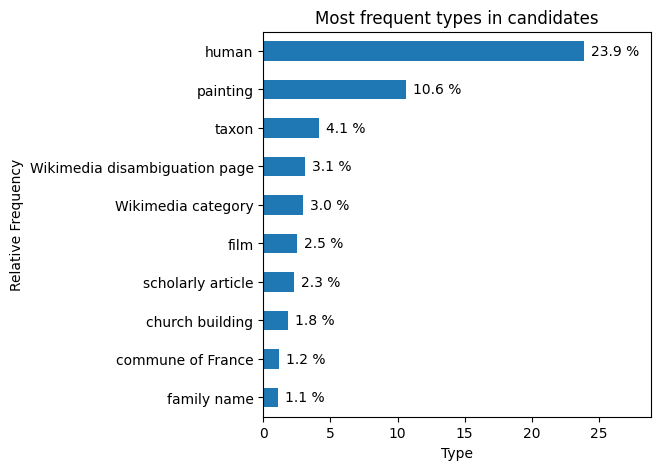

In [87]:
# count of types
type_counts=df_types['type_label'].value_counts()
#normalize
type_counts=type_counts*100/len(candidates)
ax=type_counts.head(10).plot(kind='barh', title='Most frequent types in candidates', figsize=(5,5), xlabel='Type', ylabel='Relative Frequency', xlim=(0,max(type_counts.head(10))+5))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_candidates.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [39]:
df_types_mentions=df_types[df_types['qid'].isin(mentions_qids)]
print("Total mention types triples:", len(df_types_mentions))

Total mention types triples: 1782


[Text(5, 0, '42.9 %'),
 Text(5, 0, '4.2 %'),
 Text(5, 0, '3.6 %'),
 Text(5, 0, '2.8 %'),
 Text(5, 0, '2.3 %'),
 Text(5, 0, '2.1 %'),
 Text(5, 0, '1.6 %'),
 Text(5, 0, '1.5 %'),
 Text(5, 0, '1.4 %'),
 Text(5, 0, '1.3 %')]

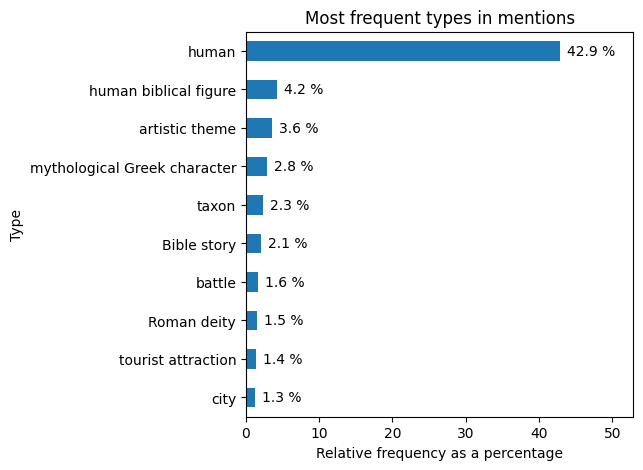

In [76]:
type_counts_mentions=df_types_mentions['type_label'].value_counts()
#normalize
type_counts_mentions=type_counts_mentions*100/len(mentions_qids)
ax=type_counts_mentions.head(10).plot(kind='barh', title='Most frequent types in mentions', figsize=(5,5), ylabel='Type', xlabel='Relative frequency as a percentage', xlim=(0,max(type_counts_mentions.head(10))+10))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)

[Text(0, 5, '42.9 %'),
 Text(0, 5, '4.2 %'),
 Text(0, 5, '3.6 %'),
 Text(0, 5, '2.8 %'),
 Text(0, 5, '2.3 %'),
 Text(0, 5, '2.1 %'),
 Text(0, 5, '1.6 %'),
 Text(0, 5, '1.5 %'),
 Text(0, 5, '1.4 %'),
 Text(0, 5, '1.3 %'),
 Text(0, 5, '1.2 %'),
 Text(0, 5, '1.1 %'),
 Text(0, 5, '1.0 %'),
 Text(0, 5, '1.0 %'),
 Text(0, 5, '1.0 %'),
 Text(0, 5, '1.0 %'),
 Text(0, 5, '0.8 %'),
 Text(0, 5, '0.8 %'),
 Text(0, 5, '0.7 %'),
 Text(0, 5, '0.7 %'),
 Text(0, 5, '0.6 %'),
 Text(0, 5, '0.6 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %'),
 Text(0, 5, '0.5 %')]

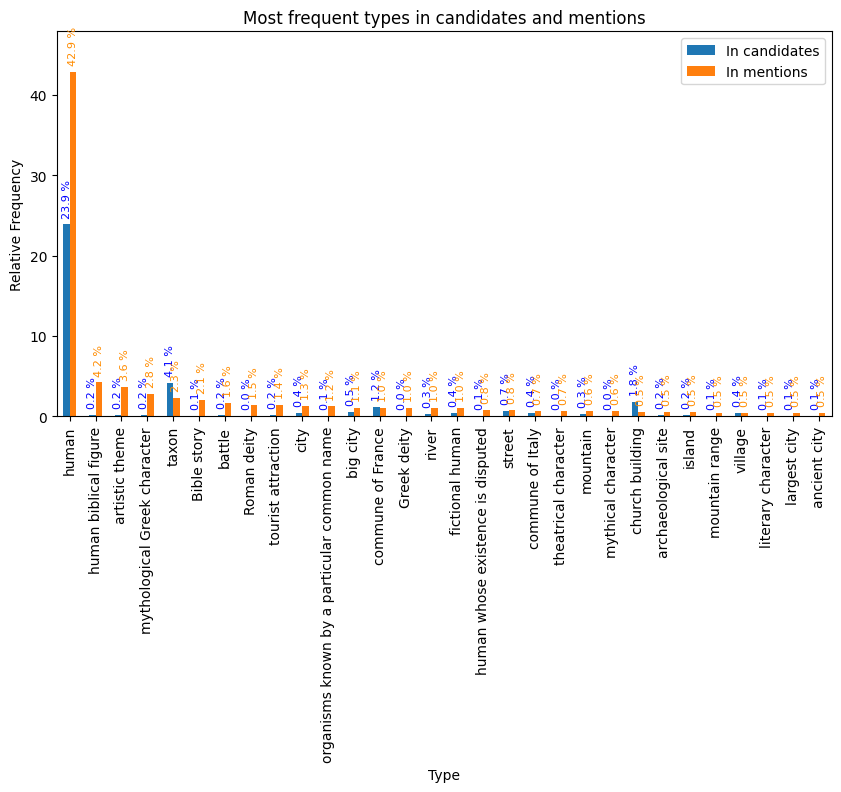

In [56]:
# combine the two type_count series into a dataframe
df_type_counts=pd.concat([type_counts, type_counts_mentions], axis=1)
df_type_counts.fillna(0, inplace=True)
df_type_counts.columns=['In candidates','In mentions']
df_type_counts.sort_values(by='In mentions', ascending=False, inplace=True)
ax=df_type_counts.head(30).plot(kind='bar', title='Most frequent types in candidates and mentions', figsize=(10,5), xlabel='Type', ylabel='Relative Frequency', ylim=(0,max(df_type_counts.head(30).max())+5), legend=True)
ax.bar_label(ax.containers[0], fmt='%.1f %%', rotation=90, padding=5, color='blue', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f %%', rotation=90, padding=5, color='darkorange', fontsize=8)